In [1]:
from pyexpat import model
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os
import locale
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from keras.preprocessing.image import ImageDataGenerator
from sklearn import preprocessing
import locale
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#import seaborn as sns

2023-11-15 20:55:01.436443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
def create_cnn(width, height, depth, filters=(16, 32, 64)):
    model = Sequential()
    model.add(Conv2D(64,kernel_size=(3,3), activation = 'relu', input_shape = (320,320,9), kernel_regularizer = 'l2'))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Conv2D(32,kernel_size=(3,3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Conv2D(16,kernel_size=(3,3),activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2, strides = 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(8,activation = 'relu'))
    model.add(Dense(4,activation = 'relu'))
    return model

In [18]:
def create_mlp(dim):
	# define our MLP network
  model = Sequential()
  model.add(Dense(128, activation = 'relu', input_shape=(dim,),kernel_regularizer = 'l2'))
  model.add(Dense(64, activation = 'relu'))
  model.add(Dense(16, activation = 'relu'))
  return model

In [24]:
gasdata = pd.read_csv("/Users/wzhang/Documents/data5.csv")
data_dir = '/Users/wzhang/Downloads/Data5'
imagedata = sorted(os.listdir(data_dir))
print(len(imagedata))
X_data = []
for image in imagedata:
        print(image)
        img = mpimg.imread('/Users/wzhang/Downloads/Data5/'+image)
        cv2.imshow("Image",img)
        img = img.reshape(320,320,9)
        img = img/255.0
        X_data.append(img)
images = np.array(X_data)


1000
A00001.png
A00002.png
A00003.png
A00004.png
A00005.png
A00006.png
A00007.png
A00008.png
A00009.png
A00010.png
A00011.png
A00012.png
A00013.png
A00014.png
A00015.png
A00016.png
A00017.png
A00018.png
A00019.png
A00020.png
A00021.png
A00022.png
A00023.png
A00024.png
A00025.png
A00026.png
A00027.png
A00028.png
A00029.png
A00030.png
A00031.png
A00032.png
A00033.png
A00034.png
A00035.png
A00036.png
A00037.png
A00038.png
A00039.png
A00040.png
A00041.png
A00042.png
A00043.png
A00044.png
A00045.png
A00046.png
A00047.png
A00048.png
A00049.png
A00050.png
A00051.png
A00052.png
A00053.png
A00054.png
A00055.png
A00056.png
A00057.png
A00058.png
A00059.png
A00060.png
A00061.png
A00062.png
A00063.png
A00064.png
A00065.png
A00066.png
A00067.png
A00068.png
A00069.png
A00070.png
A00071.png
A00072.png
A00073.png
A00074.png
A00075.png
A00076.png
A00077.png
A00078.png
A00079.png
A00080.png
A00081.png
A00082.png
A00083.png
A00084.png
A00085.png
A00086.png
A00087.png
A00088.png
A00089.png
A00090.png
A0009

In [28]:
split = train_test_split(gasdata, images, test_size=0.2)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split
trainy = trainAttrX["Gas"]
testy = testAttrX["Gas"]
trainAttrX = trainAttrX.drop(columns=['Gas'])
testAttrX = testAttrX.drop(columns = ['Gas'])
trainAttrX= (trainAttrX - np.min(trainAttrX)) / (np.max(trainAttrX) - np.min(trainAttrX))
testAttrX = (testAttrX - np.min(testAttrX)) / (np.max(testAttrX) - np.min(testAttrX))
print(trainAttrX)
print(testAttrX)
print(trainy)
print(testy)


          MQ2       MQ7
170  0.773392  0.555556
71   0.881579  0.671053
457  0.653509  0.459064
213  0.609649  0.453216
276  0.713450  0.546784
..        ...       ...
325  0.589181  0.447368
774  0.899123  0.779240
916  0.979532  0.826023
965  0.937135  0.745614
269  0.817251  0.675439

[800 rows x 2 columns]
          MQ2       MQ7
473  0.845133  0.706490
849  0.992625  0.842183
491  0.837758  0.573746
497  0.871681  0.626844
6    0.882006  0.699115
..        ...       ...
601  0.834808  0.346608
292  0.628319  0.480826
92   0.679941  0.483776
93   0.675516  0.479351
44   0.616519  0.442478

[200 rows x 2 columns]
170    0
71     0
457    0
213    0
276    0
      ..
325    0
774    1
916    1
965    1
269    0
Name: Gas, Length: 800, dtype: int64
473    0
849    1
491    0
497    0
6      0
      ..
601    1
292    0
92     0
93     0
44     0
Name: Gas, Length: 200, dtype: int64


In [29]:
mlp = create_mlp(trainAttrX.shape[1])
cnn = create_cnn(320, 320, 9)
combinedInput = concatenate([mlp.output, cnn.output])
print(mlp.output)
print(cnn.output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='dense_21/Relu:0', description="created by layer 'dense_21'")
KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), name='dense_23/Relu:0', description="created by layer 'dense_23'")


In [30]:
x = Dense(8, activation="relu")(combinedInput)
x = Dense(1, activation = "sigmoid")(x)

In [31]:
model = Model(inputs=[mlp.input, cnn.input],outputs = x)


In [32]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), loss=tf.losses.BinaryCrossentropy(),metrics = ['accuracy']) 
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 conv2d_9_input (InputLayer  [(None, 320, 320, 9)]        0         []                            
 )                                                                                                
                                                                                                  
 conv2d_9 (Conv2D)           (None, 318, 318, 64)         5248      ['conv2d_9_input[0][0]']      
                                                                                                  
 max_pooling2d_9 (MaxPoolin  (None, 159, 159, 64)         0         ['conv2d_9[0][0]']            
 g2D)                                                                                             
                                                                                            

In [35]:
hist = model.fit(x=[trainAttrX, trainImagesX], y=trainy,validation_data=([testAttrX, testImagesX], testy),epochs=10)


Epoch 1/10
25/25 [==============================] - 198s 8s/step - loss: 0.4201 - accuracy: 0.9488 - val_loss: 0.3631 - val_accuracy: 0.9700
Epoch 2/10
25/25 [==============================] - 105s 4s/step - loss: 0.3728 - accuracy: 0.9600 - val_loss: 0.3225 - val_accuracy: 0.9750
Epoch 3/10
25/25 [==============================] - 93s 4s/step - loss: 0.3330 - accuracy: 0.9638 - val_loss: 0.2869 - val_accuracy: 0.9750
Epoch 4/10
25/25 [==============================] - 108s 4s/step - loss: 0.2962 - accuracy: 0.9700 - val_loss: 0.2728 - val_accuracy: 0.9900
Epoch 5/10
25/25 [==============================] - 78s 3s/step - loss: 0.2725 - accuracy: 0.9750 - val_loss: 0.2395 - val_accuracy: 0.9950
Epoch 6/10
25/25 [==============================] - 86s 3s/step - loss: 0.2452 - accuracy: 0.9800 - val_loss: 0.2102 - val_accuracy: 0.9850
Epoch 7/10
25/25 [==============================] - 114s 5s/step - loss: 0.2182 - accuracy: 0.9850 - val_loss: 0.1949 - val_accuracy: 0.9950
Epoch 8/10
25/25

In [36]:
print(hist.history)


{'loss': [0.42007899284362793, 0.37284332513809204, 0.33296167850494385, 0.2962456941604614, 0.27252909541130066, 0.24516311287879944, 0.2182277888059616, 0.1972728669643402, 0.18238864839076996, 0.16908270120620728], 'accuracy': [0.9487500190734863, 0.9599999785423279, 0.9637500047683716, 0.9700000286102295, 0.9750000238418579, 0.9800000190734863, 0.9850000143051147, 0.9850000143051147, 0.9862499833106995, 0.987500011920929], 'val_loss': [0.3630906939506531, 0.3224712014198303, 0.28692859411239624, 0.27283012866973877, 0.2395230233669281, 0.21023020148277283, 0.19489926099777222, 0.1734066605567932, 0.16151967644691467, 0.15042516589164734], 'val_accuracy': [0.9700000286102295, 0.9750000238418579, 0.9750000238418579, 0.9900000095367432, 0.9950000047683716, 0.9850000143051147, 0.9950000047683716, 0.9950000047683716, 1.0, 1.0]}


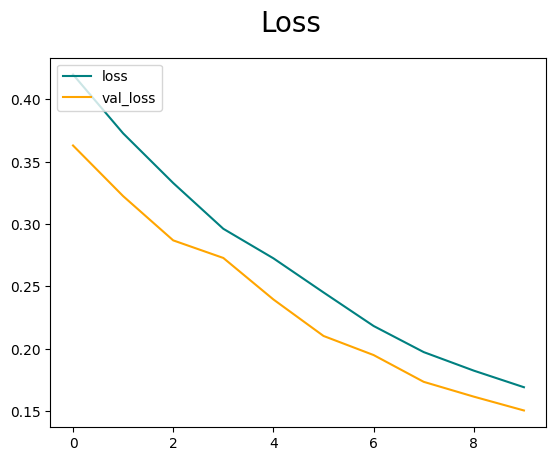

In [37]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
fig.suptitle('Loss', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

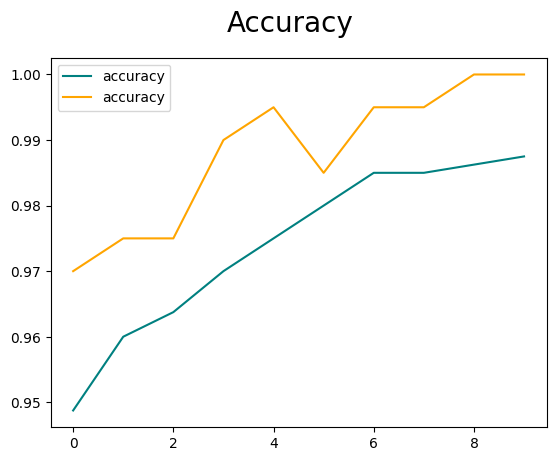

In [38]:
fig2 = plt.figure()
plt.plot(hist.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'orange', label = 'accuracy')
fig2.suptitle('Accuracy', fontsize = 20)
plt.legend(loc = "upper left")
plt.show()

In [39]:
accuracy = model.evaluate([testAttrX, testImagesX],testy)
print(accuracy)
performance = model.predict([testAttrX,testImagesX])
actual = []
for value in performance: 
    if(value>=0.5):
         actual.append(1)
    else:
        actual.append(0)
precision = precision_score(testy, actual)
print('Precision: %f' % precision)
recall = recall_score(testy, actual)
print('Recall: %f' % recall)
f1 = f1_score(testy, actual)
print('F1 score: %f' % f1)

7/7 [==============================] - 9s 973ms/step - loss: 0.1504 - accuracy: 1.0000
[0.15042516589164734, 1.0]
7/7 [==============================] - 9s 1s/step
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


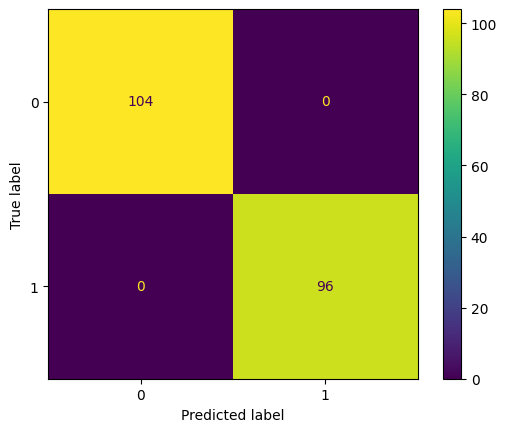

In [40]:
cm = confusion_matrix(testy, actual)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [73]:
testData = sorted(os.listdir('/Users/wzhang/Downloads/No Gas 2'))
data = pd.read_csv("/Users/wzhang/Downloads/Gas Sensors Data - No Gas (3).csv")
labels = data["Gas"]
data = data.drop(columns=['Gas'])
data = (data - np.min(data)) / (np.max(data) - np.min(data))
imgs = []
for image in testData:
    if image == '.DS_Store':
        continue
    img = mpimg.imread('/Users/wzhang/Downloads/No Gas 2/'+image)
    img = np.resize(img,(960,960))
    img = img.reshape(320, 320, 9)
    img = img/255.0
    imgs.append(img)
images = np.array(imgs)
data = np.array(data)
accuracy = model.evaluate([data, images],labels)
print(accuracy)
performance = model.predict([data,images])
actual = []
for value in performance: 
    if(value>=0.5):
         actual.append(1)
    else:
        actual.append(0)
print(actual)
precision = precision_score(labels, actual)
print('Precision: %f' % precision)
recall = recall_score(labels, actual)
print('Recall: %f' % recall)
f1 = f1_score(labels, actual)
print('F1 score: %f' % f1)

4/4 [==============================] - 3s 594ms/step - loss: 0.3634 - accuracy: 0.9344
[0.36343905329704285, 0.9344262480735779]
4/4 [==============================] - 3s 593ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1]
Precision: 1.000000
Recall: 0.333333
F1 score: 0.500000
